In [20]:
import pandas as pd #importing essential library 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
#renamed the files to make it more accessible and intuitive.
#reading csv files into pd dataframes for manipulation and data wrangling
cardholder_acc = pd.read_csv('../csvs_datathon/accy_dim.csv')
statement_data = pd.read_csv('../csvs_datathon/statement_fact.csv')
transaction_data = pd.read_csv('../csvs_datathon/transaction_fact.csv')
wrld_transaction_data = pd.read_csv('../csvs_datathon/wrld_stor_tran_fact.csv')
customer_id = pd.read_csv('../csvs_datathon/syf_id.csv')
acc_lvl_features = pd.read_csv('../csvs_datathon/rams_batch_cur.csv')
fraud_claim_case = pd.read_csv('../csvs_datathon/fraud_claim_case.csv')
fraud_claim_tran = pd.read_csv('../csvs_datathon/fraud_claim_tran.csv')

In [22]:
transaction_data

,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,payment_type,transaction_return_cnt,transaction_sale_cnt,product_amt,product_qty,...,first_purchase_ind,adj_orgn_tran_dt,curr_markup_fee,fcr_amount,fcr_flag,fcr_rate_of_exchange,frgn_curr_code,frgn_tran_amt,us_equiv_amt,posting_date
0,X7jfKh6xrPAB8Tx6,SALE,253,2024-06-05,15.78,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,15.78,0.0,2024-06-06
1,yntD77AZDylS48Q4,SALE,253,2024-06-19,14.85,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,14.85,0.0,2024-06-20
2,LIJPI0sK28Pa7fX2,SALE,253,2024-06-26,136.16,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,136.16,0.0,2024-06-27
3,CMAr5Apxwdzpvoze,SALE,253,2024-08-15,8.74,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,8.74,0.0,2024-08-16
4,eJSfTCGPvJulGzd3,SALE,253,2024-08-17,26.65,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,26.65,0.0,2024-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493331,ktpdvlbVRuywp2Po,SALE,253,2025-03-07,3.99,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,3.99,0.0,2025-03-07
493332,xwgOt4lvAHr517sa,SALE,253,2024-07-27,6.13,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,6.13,0.0,2024-07-28
493333,zp60CmOQNComnHDT,SALE,253,2025-02-04,15.62,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,15.62,0.0,2025-02-05
493334,8M5fnshTsgW9mW8Y,PAYMENT,271,2025-02-05,100.00,NaN,0,0,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,"\""\""",0.00,0.0,2025-02-05


In [23]:
transaction_data = transaction_data[transaction_data['transaction_type'] == 'SALE']
# print(transaction_data)
transaction_data.dtypes
# print(transaction_data['transaction_date'].dtype)
transaction_data['transaction_date'] = pd.to_datetime(transaction_data['transaction_date'])
# print(transaction_data['transaction_date'].dtype)
transaction_data['year'] = transaction_data['transaction_date'].dt.year
transaction_data['month'] = transaction_data['transaction_date'].dt.month
transaction_data['day'] = transaction_data['transaction_date'].dt.day
transaction_data['dayofweek'] = transaction_data['transaction_date'].dt.dayofweek
# transaction_data['quarter'] = transaction_data['transaction_date'].dt.quarter
# transaction_data['date'] = transaction_data['transaction_date'].dt.date

transaction_data_sorted_chronological = transaction_data.sort_values(by='transaction_date', ascending=True).reset_index(drop=True)
# transaction_data_sorted
# print(transaction_data['year'].dtype)
transaction_data_sorted_chronological.head(50)
# transaction_data_sorted.tail(50)
# transaction_data_sorted.sample(50)

#filter only aug to mar

transaction_data_last8months = transaction_data_sorted_chronological[(transaction_data_sorted_chronological['transaction_date'] >= '2024-08-01') & (transaction_data_sorted_chronological['transaction_date'] <= '2025-03-24')]
transaction_data_last8months.tail()

C:\Users\csalg\AppData\Local\Temp\ipykernel_13352\2924404876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data['transaction_date'] = pd.to_datetime(transaction_data['transaction_date'])
C:\Users\csalg\AppData\Local\Temp\ipykernel_13352\2924404876.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data['year'] = transaction_data['transaction_date'].dt.year
C:\Users\csalg\AppData\Local\Temp\ipykernel_13352\2924404876.py:8: SettingWithCopyWarning: 
A value is trying to be set on

,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,payment_type,transaction_return_cnt,transaction_sale_cnt,product_amt,product_qty,...,fcr_flag,fcr_rate_of_exchange,frgn_curr_code,frgn_tran_amt,us_equiv_amt,posting_date,year,month,day,dayofweek
337918,Z87LjFfrML6krD0n,SALE,253,2025-03-24,7.03,NaN,0,1,NaN,NaN,...,NaN,NaN,840,7.03,0.0,2025-03-24,2025,3,24,0
337919,Q91RCKm3txZLZNcQ,SALE,253,2025-03-24,7.69,NaN,0,1,NaN,NaN,...,NaN,NaN,840,7.69,0.0,2025-03-24,2025,3,24,0
337920,Y2CoDNyoHzKmlbFg,SALE,253,2025-03-24,15.70,NaN,0,1,NaN,NaN,...,NaN,NaN,840,15.70,0.0,2025-03-24,2025,3,24,0
337921,20iRvjVxRfRsR7SE,SALE,253,2025-03-24,2590.69,NaN,0,1,NaN,NaN,...,NaN,NaN,840,0.00,0.0,2025-03-24,2025,3,24,0
337922,PaNbnqmYXSNH235O,SALE,253,2025-03-24,29.22,NaN,0,1,NaN,NaN,...,NaN,NaN,840,29.22,0.0,2025-03-24,2025,3,24,0


In [24]:
import statsmodels.formula.api as smf
# transaction_data_last8months.isna().sum()
# transaction_type, transaction_code, payment_type, transaction_return_cnt, transaction_sale_cnt, 
# product_amt, product_qty, fcr_flag, fcr_rate_of_exchange, frgn_tran_amt, us_equiv_amt, year, month, dayofweek
results = smf.ols('transaction_amt ~ transaction_type + year + month + dayofweek + us_equiv_amt + frgn_tran_amt + us_equiv_amt + transaction_sale_cnt', data=transaction_data_last8months).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        transaction_amt   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 2.208e+06
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:30:14   Log-Likelihood:            -1.2630e+06
No. Observations:              228815   AIC:                         2.526e+06
Df Residuals:                  228810   BIC:                         2.526e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              298.3500 

In [25]:
# transaction_data_last8months.dtypes
def create_customer_df(account_id):
    df = transaction_data_last8months[transaction_data_last8months['current_account_nbr'] == account_id]
    return df

In [26]:
# TEST FUNCTIONS

my_df = create_customer_df('Z87LjFfrML6krD0n')
my_df

,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,payment_type,transaction_return_cnt,transaction_sale_cnt,product_amt,product_qty,...,fcr_flag,fcr_rate_of_exchange,frgn_curr_code,frgn_tran_amt,us_equiv_amt,posting_date,year,month,day,dayofweek
118076,Z87LjFfrML6krD0n,SALE,253,2024-08-10,24.24,NaN,0,1,NaN,NaN,...,NaN,NaN,840,24.24,0.0,2024-08-12,2024,8,10,5
119034,Z87LjFfrML6krD0n,SALE,253,2024-08-12,22.04,NaN,0,1,NaN,NaN,...,NaN,NaN,840,22.04,0.0,2024-08-13,2024,8,12,0
124612,Z87LjFfrML6krD0n,SALE,253,2024-08-18,5.28,NaN,0,1,NaN,NaN,...,NaN,NaN,840,5.28,0.0,2024-08-19,2024,8,18,6
125610,Z87LjFfrML6krD0n,SALE,253,2024-08-19,40.97,NaN,0,1,NaN,NaN,...,NaN,NaN,840,40.97,0.0,2024-08-20,2024,8,19,0
128327,Z87LjFfrML6krD0n,SALE,253,2024-08-22,10.90,NaN,0,1,NaN,NaN,...,NaN,NaN,840,10.90,0.0,2024-08-23,2024,8,22,3
128777,Z87LjFfrML6krD0n,SALE,253,2024-08-22,13.21,NaN,0,1,NaN,NaN,...,NaN,NaN,840,13.21,0.0,2024-08-23,2024,8,22,3
147379,Z87LjFfrML6krD0n,SALE,253,2024-09-12,19.79,NaN,0,1,NaN,NaN,...,NaN,NaN,840,19.79,0.0,2024-09-13,2024,9,12,3
151337,Z87LjFfrML6krD0n,SALE,253,2024-09-16,11.01,NaN,0,1,NaN,NaN,...,NaN,NaN,840,11.01,0.0,2024-09-17,2024,9,16,0
154097,Z87LjFfrML6krD0n,SALE,253,2024-09-20,41.65,NaN,0,1,NaN,NaN,...,NaN,NaN,840,41.65,0.0,2024-09-22,2024,9,20,4
159668,Z87LjFfrML6krD0n,SALE,253,2024-09-26,17.63,NaN,0,1,NaN,NaN,...,NaN,NaN,840,17.63,0.0,2024-09-27,2024,9,26,3


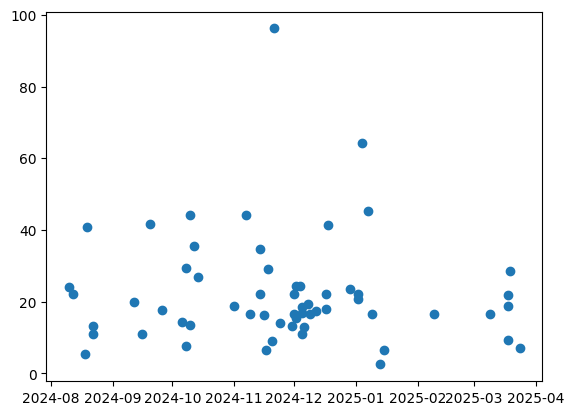

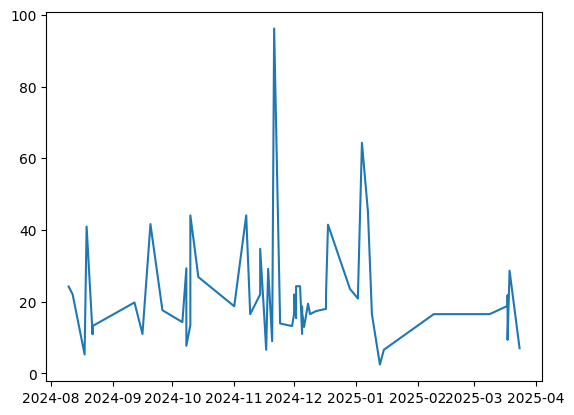

In [27]:
# visualizations test

plt.scatter(my_df['transaction_date'], my_df['transaction_amt'])
plt.show()

plt.plot(my_df['transaction_date'], my_df['transaction_amt'])
plt.show()

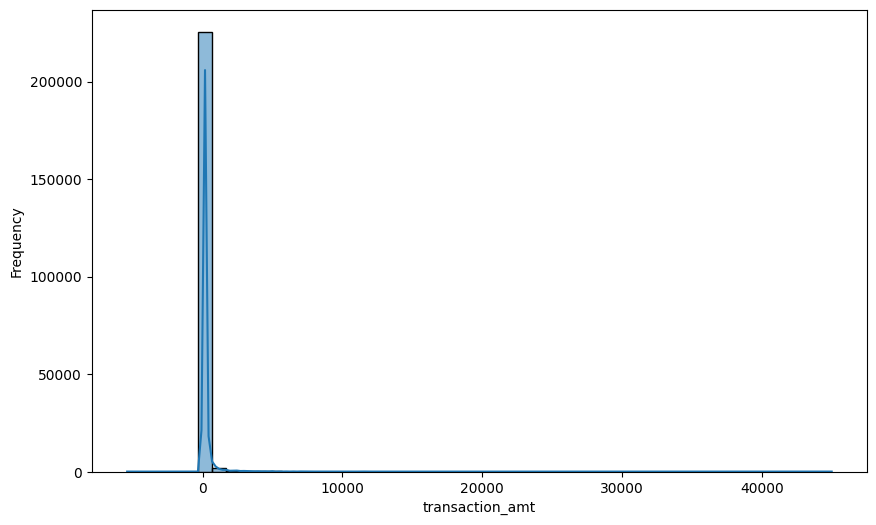

In [28]:
transaction_data_last8months['transaction_amt'].describe()

# check dist
plt.figure(figsize=(10, 6))
sns.histplot(transaction_data_last8months['transaction_amt'], bins=50, kde=True)
plt.xlabel('transaction_amt')
plt.ylabel('Frequency')
plt.show()


In [29]:
#exclude outliers

transaction_data_last8months

mean_amt = transaction_data_last8months['transaction_amt'].mean()
std_amt = transaction_data_last8months['transaction_amt'].std()

print(mean_amt)
print(std_amt)

lower_bound = mean_amt - 3 * std_amt
upper_bound = mean_amt + 3 * std_amt

#filter data
filtered_transaction_data_no_outliers = transaction_data_last8months[(transaction_data_last8months['transaction_amt'] >= lower_bound) &
                                                         (transaction_data_last8months['transaction_amt'] <= upper_bound)]


89.64894561108316
379.91276263640043


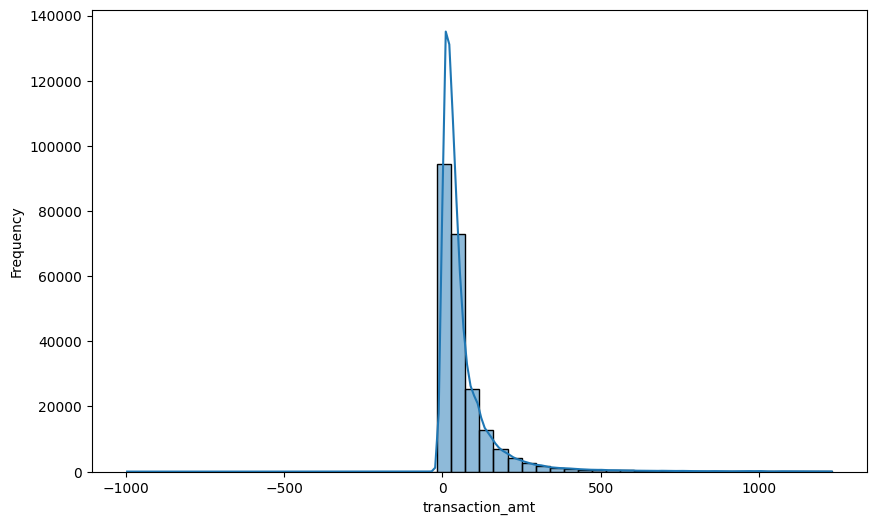

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_transaction_data_no_outliers['transaction_amt'], bins=50, kde=True)
plt.xlabel('transaction_amt')
plt.ylabel('Frequency')
plt.show()

In [31]:
# set index with transaction date
filtered_transaction_data_no_outliers.set_index('transaction_date', inplace=True)
# resample by month aggregate to get the sum
monthly_transaction_data = (filtered_transaction_data_no_outliers.groupby('current_account_nbr').resample('M')['transaction_amt'].sum().reset_index())
monthly_transaction_data.set_index('transaction_date', inplace=True)
monthly_transaction_data.head(50)

,current_account_nbr,transaction_amt
transaction_date,,
2025-03-31,00gwujJkd597VxLd,25.90
2024-08-31,00iP5U82D8XwVQ9G,423.06
2024-09-30,00iP5U82D8XwVQ9G,437.46
2024-10-31,00iP5U82D8XwVQ9G,564.90
2024-11-30,00iP5U82D8XwVQ9G,621.91
2024-12-31,00iP5U82D8XwVQ9G,653.08
2025-01-31,00iP5U82D8XwVQ9G,487.03
2025-02-28,00iP5U82D8XwVQ9G,332.02
2025-03-31,00iP5U82D8XwVQ9G,385.30


In [32]:
test_transaction_data = monthly_transaction_data[monthly_transaction_data['current_account_nbr'] == 'Z87LjFfrML6krD0n']
test_transaction_data

,current_account_nbr,transaction_amt
transaction_date,,
2024-08-31,Z87LjFfrML6krD0n,116.64
2024-09-30,Z87LjFfrML6krD0n,90.08
2024-10-31,Z87LjFfrML6krD0n,171.35
2024-11-30,Z87LjFfrML6krD0n,320.54
2024-12-31,Z87LjFfrML6krD0n,320.65
2025-01-31,Z87LjFfrML6krD0n,178.01
2025-02-28,Z87LjFfrML6krD0n,16.53
2025-03-31,Z87LjFfrML6krD0n,102.18


In [33]:
adf_result = adfuller(monthly_transaction_data['transaction_amt'])
adf_result

(-47.902477046599586,
 0.0,
 16,
 49622,
 {'1%': -3.430481789091726,
  '5%': -2.8615982480621764,
  '10%': -2.566801003518761},
 726974.8238109618)

In [34]:

# evaluate how good our model is first / check the mse and r2 values
def evaluate_model(account_id, transaction_data):
    account_data = transaction_data[transaction_data['current_account_nbr'] == account_id]
    account_data = account_data.sort_index()

    # first 6 months
    train_data = account_data.iloc[:-2]  
    # last 2 months
    test_data = account_data.iloc[-2:]  

    model = AutoReg(train_data['transaction_amt'], lags=2)

    predictions = model.fit().predict(start=test_data.index[0], end=test_data.index[-1])

    mse = mean_squared_error(test_data['transaction_amt'], predictions)
    r2 = r2_score(test_data['transaction_amt'], predictions)
    
    print('MSE VALUE:')
    print(mse)
    print('R² VALUE:')
    print(r2)

    return mse, r2

In [35]:

# use past data to predict q4 spending
def predict_q4_spending(account_id, transaction_data):
    account_data = transaction_data[transaction_data['current_account_nbr'] == account_id]
    # print(account_data)
    account_data = account_data.sort_index()
    # print(account_data)
    # lags - determines how far back model will look at to make prediction
    model = AutoReg(account_data['transaction_amt'], lags=2)
    
    start_date = '2025-10-01'
    end_date = '2025-12-31'
    predictions = model.fit().predict(start=start_date, end=end_date)
    # goes 10-31 then 11-30 then 12-31
    # print(predictions)
    return predictions.sum()

In [36]:
id = 'Z87LjFfrML6krD0n'

mse_and_r2 = evaluate_model(id, monthly_transaction_data)
print(mse_and_r2)

sum = predict_q4_spending(id, monthly_transaction_data)
print(sum)



MSE VALUE:
695.7382595316521
R² VALUE:
0.6206403437159254
(695.7382595316521, 0.6206403437159254)
840.5117180083491


c:\Users\csalg\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\csalg\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\csalg\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\csalg\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, Datet

In [37]:
wrld_transaction_data

,current_account_nbr,transaction_type,transaction_code,transaction_date,transaction_amt,payment_type,transaction_return_cnt,transaction_sale_cnt,product_amt,product_qty,...,first_purchase_ind,adj_orgn_tran_dt,curr_markup_fee,fcr_amount,fcr_flag,fcr_rate_of_exchange,frgn_curr_code,frgn_tran_amt,us_equiv_amt,posting_date
0,8DPC9336FwGf8TPz,SALE,253,2024-04-29,47.40,NaN,0,1,NaN,NaN,...,N,2024-03-17,0.0,NaN,NaN,NaN,840,47.40,0.0,2024-04-30
1,DRTiAtZURdSfMAB0,SALE,253,2024-06-25,87.13,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,87.13,0.0,2024-06-27
2,4y1CqjRDtP3w8Nb5,SALE,253,2024-08-06,30.00,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,30.00,0.0,2024-08-07
3,3dPDITyRPlzdq3wf,SALE,253,2024-09-05,32.30,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,32.30,0.0,2024-09-05
4,q1mnsZTeAaQH71AF,SALE,253,2024-12-30,4.40,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,4.40,0.0,2024-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053849,uqlll7MEoZkj3vur,SALE,253,2024-11-12,9.57,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,9.57,0.0,2024-11-13
1053850,ZGjYc8aETjtytUYR,SALE,253,2025-03-10,16.11,NaN,0,1,NaN,NaN,...,N,NaN,0.0,NaN,NaN,NaN,840,16.11,0.0,2025-03-11
1053851,4JpGONAzyfmoxi7A,SALE,253,2025-03-20,20.37,NaN,0,1,NaN,NaN,...,N,2025-02-26,0.0,NaN,NaN,NaN,840,20.37,0.0,2025-03-21
1053852,tUUUlJJZ2ETedT7g,SALE,253,2024-11-21,180.00,NaN,0,1,NaN,NaN,...,N,2024-11-12,0.0,NaN,NaN,NaN,840,180.00,0.0,2024-11-22
